In [1]:
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
#import hvplot.pandas
#import datashader as ds
#from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


First we are going to set up a few functions up front to help with analyzing and viewing our data and models later on

In [2]:
# A function to assess the bad and good data points (0 or 1) for the training, testing and total data sets
def assessTrainTestData(trainData, testData):
    
    totalTrainData = cmTrain.shape[0]
    badTrainData = totalTrainData-cmTrain['goodPts'].sum()
    fracTrainData=badTrainData / totalTrainData

    totalTestData = cmTest.shape[0]
    badTestData = totalTestData-cmTest['goodPts'].sum()
    fracTestData=badTestData / totalTestData

    print('Training Data Points')
    print(totalTrainData)

    print('Data manually QCed as 0 or bad')
    print(badTrainData)

    print('Fraction of data points which are bad')
    print(fracTrainData)

    print('\n')

    print('Testing Data Points')
    print(totalTestData)

    print('Data manually QCed as 0 or bad')
    print(badTestData)

    print('Fraction of data points which are bad')
    print(fracTestData)
    
    return totalTrainData,badTrainData

In [3]:
# a function to plot the confusion matrix
def plotConfusionMatrix(cnfMatrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                        ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cnfMatrix
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    #Calculate the total accuracy - for all points
    print('total accuracy = '+
          '{:.4f}'.format((cnfMatrix[0,0]+cnfMatrix[1,1])/cnfMatrix.sum())
         )
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    xtick_marks = np.array([0,1])
    plt.xticks(xtick_marks, classes)
    ytick_marks=np.array([-.5,0,1,1.5])
    ylabels=['',classes[0],classes[1],'']
    plt.yticks(ytick_marks, ylabels,rotation=0)
    plt.colorbar()
    return

This is function to combine the steps of setting up, fitting and evaluating our NN model

In [4]:
def runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, 
               epochCount, batchCount, classThreshold, numFeatures):

    """
    where: 
        featureTrain = features used in training the model
        targetTrain = targets (0 or 1) used in training the model
        featureTest = features used for validation
        targetTest = targets (0 or 1) used for valdation
        predictFeatures = 
        epochCount = number of training cycles to use for NN model (10-20 seems reasonable)
        batchCount = the batch size to use when training (somewhere from 32-256 seems reasonable)
        classThreshold = the threshold from 0 to 1 used to classify a point as good or bad (default is 0.5)
        numFeatures = the number of input features in the NN model
    """

    #First define the keras NN framework to be used
    # For a single-input model with 2 classes (binary classification):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=numFeatures))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model, iterating on the data in batches of X # samples (somewhere between 32 - 256)
    history = model.fit(featureTrain, targetTrain, epochs=epochCount, batch_size=batchCount, validation_data=(featureTest, targetTest))
    
    #Evaulate the model
    eval_model=model.evaluate(featureTest, targetTest)
    eval_model
    
    #Plot the NN accuracy over each epoch
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.legend(['Training','Validation'])
    plt.show()
    #fig.savefig('NN_modelTrainingHistory.png')
    
    #Generate predictions for the test period
    modelPrediction = model.predict(featureTest, batch_size=32)

    #And now use the threhsold to decide y or n
    modelPredThresh=1*(modelPrediction >= classThreshold)

    # Compute confusion matrix
    cnfMatrix = confusion_matrix(targetTest, modelPredThresh)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    classNames = ['bad data point','good data point']
    plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                      title='Confusion matrix, with normalization')
    plt.show()
    
    #Generate model predictions for the validation period
    modelPrediction = model.predict(predictFeatures, batch_size=32)
    #Generate the y/n prediction given the above model threshold value (right now = 0.9)
    modelPredThresh=1*(modelPrediction >= classThreshold)
    
    modelOut = pd.DataFrame()
    modelOut['primary'] = cmTest['primary']
    modelOut['modelPrediction']=modelPrediction
    modelOut['InvModelPrediction']=1-modelPrediction
    modelOut['goodPtsPrediction']=modelPredThresh
    modelOut['goodPts'] = cmTest.loc[:,['goodPts']]
    
    return modelOut


Read in the data from the files and do some initial prep

In [5]:
cleaned = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned.p"))
targets = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Target.p"))

#Lets add residual (primary - prediction)
cleaned['residual']=cleaned['primary']-cleaned['prediction']

#Combining the cleaned structure with targets for ease of use purposes
cleaned['goodPts']=targets['goodPts']

#Set the index as the time and change to datetime
cleaned.set_index('time', inplace = True)
cleaned.index = pd.to_datetime(cleaned.index)

cleaned.head()

,primary,sigma,backup,verified,prediction,residual,goodPts
time,,,,,,,
2007-01-01 00:00:00,0.459,0.006,0.446,0.459,0.385,0.074,1
2007-01-01 00:06:00,0.437,0.005,0.425,0.437,0.365,0.072,1
2007-01-01 00:12:00,0.400,0.006,0.388,0.400,0.344,0.056,1
2007-01-01 00:18:00,0.376,0.006,0.363,0.376,0.321,0.055,1
2007-01-01 00:24:00,0.354,0.006,0.342,0.354,0.297,0.057,1


In [6]:
cleanedLewes = pd.read_pickle(Path("pickle_files/8557380_lewes_raw_ver_merged_wl_Cleaned.p"))

#Lets add residual (primary - prediction)
cleanedLewes['residual']=cleanedLewes['primary']-cleanedLewes['prediction']

#Set the index as the time and change to datetime
cleanedLewes.set_index('time', inplace = True)
cleanedLewes.index = pd.to_datetime(cleanedLewes.index)

cleanedLewes.head()

,primary,sigma,backup,verified,prediction,residual
time,,,,,,
2007-01-01 00:00:00,0.360,0.004,0.370,0.360,0.292,0.068
2007-01-01 00:06:00,0.342,0.008,0.348,0.342,0.278,0.064
2007-01-01 00:12:00,0.318,0.004,0.326,0.318,0.263,0.055
2007-01-01 00:18:00,0.306,0.007,0.315,0.306,0.247,0.059
2007-01-01 00:24:00,0.271,0.013,0.282,0.271,0.229,0.042


Now lets take the residual data and add it to the cleaned cape may dataframe

In [7]:
cleaned['neighborResidual']=cleanedLewes['residual']
cleaned.head()

,primary,sigma,backup,verified,prediction,residual,goodPts,neighborResidual
time,,,,,,,,
2007-01-01 00:00:00,0.459,0.006,0.446,0.459,0.385,0.074,1,0.068
2007-01-01 00:06:00,0.437,0.005,0.425,0.437,0.365,0.072,1,0.064
2007-01-01 00:12:00,0.400,0.006,0.388,0.400,0.344,0.056,1,0.055
2007-01-01 00:18:00,0.376,0.006,0.363,0.376,0.321,0.055,1,0.059
2007-01-01 00:24:00,0.354,0.006,0.342,0.354,0.297,0.057,1,0.042


Since the neighbor station will have some missing data points for when CM data is present but Lewes isnt - I am going to replace null values with 0 and then add a binary 0,1 feature that is 0 when missing and 1 when present.

In [8]:
neighborTrue = cleaned['neighborResidual'].notnull()
cleaned['neighborTrue'] = neighborTrue * 1

test = cleaned['neighborResidual'].fillna(value=0, inplace = True)
cleaned.head()

,primary,sigma,backup,verified,prediction,residual,goodPts,neighborResidual,neighborTrue
time,,,,,,,,,
2007-01-01 00:00:00,0.459,0.006,0.446,0.459,0.385,0.074,1,0.068,1
2007-01-01 00:06:00,0.437,0.005,0.425,0.437,0.365,0.072,1,0.064,1
2007-01-01 00:12:00,0.400,0.006,0.388,0.400,0.344,0.056,1,0.055,1
2007-01-01 00:18:00,0.376,0.006,0.363,0.376,0.321,0.055,1,0.059,1
2007-01-01 00:24:00,0.354,0.006,0.342,0.354,0.297,0.057,1,0.042,1


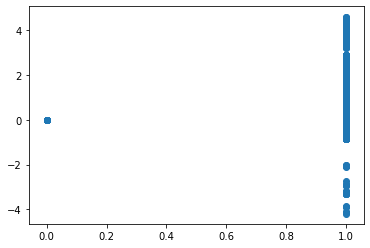

In [9]:
#Scatter to confirm that the boolean was executed properly - there should be data points at 0,0 and a range of values when x axis = 1
plt.scatter(cleaned['neighborTrue'],cleaned['neighborResidual'])

Lets try a scatter matrix to get a sense of the data and how it relates to each other (note that this was taking forever with the whole data set, so just using the first year for an example)

In [10]:
#from pandas.plotting import scatter_matrix

#scatter_matrix(cleaned.loc[:'2008-12-31 23:54:00',['primary','sigma','backup','prediction']], figsize=(12,8))

Then try plotting each variable to determine if outliers should be capped or replaced

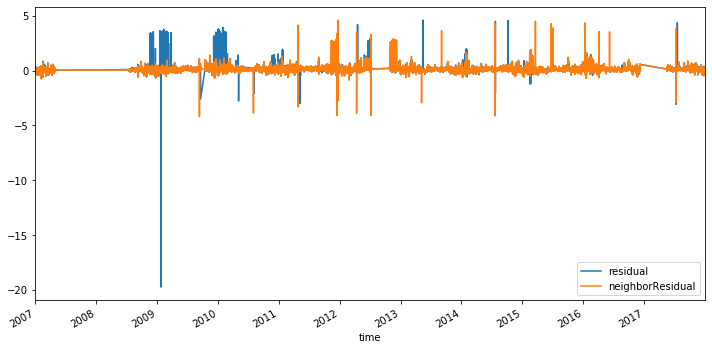

In [12]:
cleaned[['residual','neighborResidual']].plot(figsize=(12,6))

Next we need to set thresholds for outliers for each observed value and replace the outiers with the max or min threshold value

In [13]:
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] >5, 5)
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] < -5, -5)

cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] >5, 5)
cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] < -5, -5)

cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] >5, 5)
cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] < -5, -5)

cleaned['neighborResidual'] = cleaned['neighborResidual'].mask(cleaned['neighborResidual'] >5, 5)
cleaned['neighborResidual'] = cleaned['neighborResidual'].mask(cleaned['neighborResidual'] < -5, -5)

cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] > 1, 1)
cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] < 0, 0)

Break up into training and test sections, 

In [14]:
cmTrain = cleaned.loc[:'2014-12-31 23:54:00']
cmTest = cleaned.loc['2015-01-01 00:00:00':]
cmTest.head()

,primary,sigma,backup,verified,prediction,residual,goodPts,neighborResidual,neighborTrue
time,,,,,,,,,
2015-01-01 00:00:00,0.136,0.007,0.156,0.136,0.168,-0.032,1,-0.048,1
2015-01-01 00:06:00,0.094,0.007,0.114,0.094,0.134,-0.040,1,-0.043,1
2015-01-01 00:12:00,0.055,0.007,0.075,0.055,0.099,-0.044,1,-0.057,1
2015-01-01 00:18:00,0.018,0.006,0.039,0.018,0.063,-0.045,1,-0.054,1
2015-01-01 00:24:00,-0.009,0.006,0.012,-0.009,0.027,-0.036,1,-0.050,1


Calculate the standard scalar to demean and scale each feature by its standard deviation.  The scalar should be calculated on the training data set and then applied to both the training and testing set.  This is because in theory we should not yet know what the distribution of the testing set would be when creating our model.

In [15]:
# Get column names first
names = ['primary','sigma','backup','prediction','residual','neighborResidual']
# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
cmTrainScaled = scaler.fit_transform(cmTrain.loc[:,['primary','sigma','backup','prediction','residual','neighborResidual']])
cmTrainScaled = pd.DataFrame(cmTrainScaled, columns=names)
cmTrainScaled.set_index(cmTrain.index, inplace = True)
cmTrainScaled[['goodPts','neighborTrue']]=cmTrain[['goodPts','neighborTrue']]


#Apply the fit to the test data
cmTestScaled = scaler.transform(cmTest.loc[:,['primary','sigma','backup','prediction','residual','neighborResidual']])
cmTestScaled = pd.DataFrame(cmTestScaled, columns=names)
cmTestScaled.set_index(cmTest.index, inplace = True)
cmTestScaled[['goodPts','neighborTrue']]=cmTest[['goodPts','neighborTrue']]

cmTestScaled.head()

,primary,sigma,backup,prediction,residual,neighborResidual,goodPts,neighborTrue
time,,,,,,,,
2015-01-01 00:00:00,-0.054986,-0.082504,0.084219,0.315907,-0.489993,-0.648652,1,1
2015-01-01 00:06:00,-0.118430,-0.082504,0.009047,0.253043,-0.508907,-0.628395,1,1
2015-01-01 00:12:00,-0.177341,-0.082504,-0.060756,0.188331,-0.518363,-0.685114,1,1
2015-01-01 00:18:00,-0.233231,-0.132471,-0.125189,0.121769,-0.520727,-0.672960,1,1
2015-01-01 00:24:00,-0.274016,-0.132471,-0.173514,0.055208,-0.499450,-0.656755,1,1


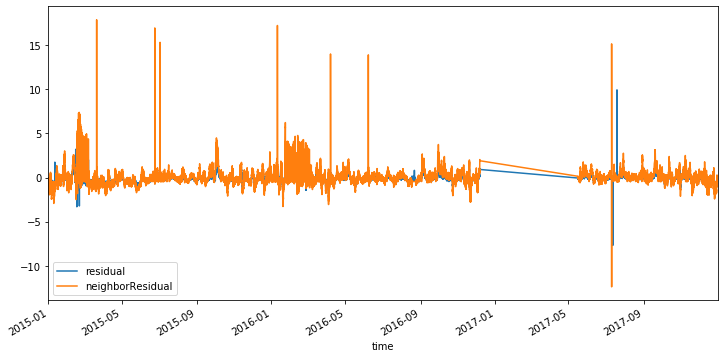

In [16]:
cmTestScaled[['residual','neighborResidual']].plot(figsize=(12,6))

Do some comparisons to see the y/n reprentations between Train and Test sets

In [17]:
(totalTrainData, noTrainData) = assessTrainTestData(cmTrain,cmTest)

Training Data Points
550665
Data manually QCed as 0 or bad
24691
Fraction of data points which are bad
0.04483851343375737


Testing Data Points
223835
Data manually QCed as 0 or bad
5179
Fraction of data points which are bad
0.02313757902026046


Shuffle the individual training and testing sections to aid with NN fit

In [18]:
cmTrainRand=shuffle(cmTrainScaled)
cmTestRand=shuffle(cmTestScaled)
cmTestRand.head()

,primary,sigma,backup,prediction,residual,neighborResidual,goodPts,neighborTrue
time,,,,,,,,
2015-11-02 15:18:00,0.238061,-0.132471,0.420703,0.480461,-0.241759,-0.320489,1,1
2015-09-19 11:30:00,-0.900895,-0.132471,-0.962821,-0.924723,-0.227574,-0.227306,1,1
2015-11-17 16:30:00,1.372485,-0.132471,1.757693,1.528802,0.193243,0.672104,1,1
2017-07-20 07:18:00,-0.219636,-0.132471,-0.180673,-0.027994,-0.307955,-0.361003,1,1
2017-05-18 20:00:00,0.464643,-0.032538,0.631901,0.706030,-0.175563,-0.170587,1,1


In [19]:
featureTrain=cmTrainRand.loc[:,['primary','sigma','backup','prediction','residual']]
featureTest=cmTestRand.loc[:,['primary','sigma','backup','prediction','residual']]

targetTrain=cmTrainRand.loc[:,['goodPts']]
targetTest=cmTestRand.loc[:,['goodPts']]

predictFeatures = cmTestScaled.loc[:,['primary','sigma','backup','prediction','residual']]

Now lets run the NN model function to fit the model and assess performance

Train on 550665 samples, validate on 223835 samples
Epoch 1/15
550665/550665 [==============================] - 16s 30us/step - loss: 0.0990 - accuracy: 0.9788 - val_loss: 0.0380 - val_accuracy: 0.9928
Epoch 2/15
550665/550665 [==============================] - 16s 28us/step - loss: 0.0761 - accuracy: 0.9841 - val_loss: 0.0308 - val_accuracy: 0.9956
Epoch 3/15
550665/550665 [==============================] - 15s 27us/step - loss: 0.0745 - accuracy: 0.9846 - val_loss: 0.0298 - val_accuracy: 0.9958
Epoch 4/15
550665/550665 [==============================] - 15s 28us/step - loss: 0.0738 - accuracy: 0.9847 - val_loss: 0.0278 - val_accuracy: 0.9962
Epoch 5/15
550665/550665 [==============================] - 15s 27us/step - loss: 0.0732 - accuracy: 0.9847 - val_loss: 0.0254 - val_accuracy: 0.9963
Epoch 6/15
550665/550665 [==============================] - 15s 28us/step - loss: 0.0727 - accuracy: 0.9847 - val_loss: 0.0272 - val_accuracy: 0.9962
Epoch 7/15
550665/550665 [======================

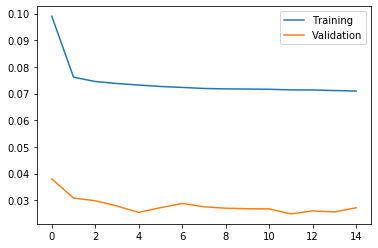

Normalized confusion matrix
[[0.89 0.11]
 [0.01 0.99]]
total accuracy = 0.9910


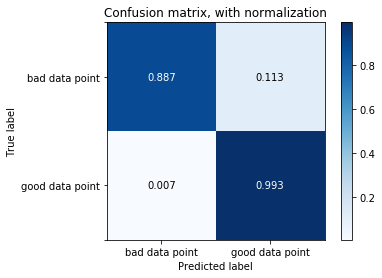

In [20]:
epochCount = 15
batchCount = 128
classThreshold = .90
numFeatures = 5
modelOut = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, 
               epochCount, batchCount, classThreshold, numFeatures)

I am now going to try to first balance the data sets to difference y/n percentages, since right now it is highly skewed towards y cases, which might be reducing the n accuracy

For more information on other ways to do this see: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

In [21]:
#First lets try doing 75% y and 25% no - randomly undersampling the y cases.

#What is the fraction of no that we want
fractionNo = 0.25

#What is the number of yes points we need to have given that No fraction
numYes = int(noTrainData * ((1-fractionNo) // fractionNo))

# Divide by class
class_0 = cmTrainRand[cmTrainRand['goodPts'] == 0]
class_1 = cmTrainRand[cmTrainRand['goodPts'] == 1]

In [22]:
#Now resample the yes or 1s to be 75% of total training data
class_1_resample = class_1.sample(numYes)
cmTrainResample = pd.concat([class_1_resample, class_0], axis=0)

print('Random under-sampling:')
print(cmTrainResample.goodPts.value_counts())

Random under-sampling:
1    74073
0    24691
Name: goodPts, dtype: int64


Now we are going to re-shuffle the data and then re run the NN model, validating on the same data set to see if there is any change in performance

In [23]:
cmTrainRandResample=shuffle(cmTrainResample)

featureTrain=cmTrainRandResample.loc[:,['primary','sigma','backup','prediction','residual']]
featureTest=cmTestRand.loc[:,['primary','sigma','backup','prediction','residual']]

targetTrain=cmTrainRandResample.loc[:,['goodPts']]
targetTest=cmTestRand.loc[:,['goodPts']]

predictFeatures = cmTestScaled.loc[:,['primary','sigma','backup','prediction','residual']]

Run the same keras NN as before but with the resampled data

Train on 98764 samples, validate on 223835 samples
Epoch 1/15
98764/98764 [==============================] - 11s 111us/step - loss: 0.2978 - accuracy: 0.9036 - val_loss: 0.1192 - val_accuracy: 0.9923
Epoch 2/15
98764/98764 [==============================] - 11s 109us/step - loss: 0.2636 - accuracy: 0.9128 - val_loss: 0.1068 - val_accuracy: 0.9948
Epoch 3/15
98764/98764 [==============================] - 11s 116us/step - loss: 0.2569 - accuracy: 0.9145 - val_loss: 0.1099 - val_accuracy: 0.9942
Epoch 4/15
98764/98764 [==============================] - 10s 104us/step - loss: 0.2525 - accuracy: 0.9160 - val_loss: 0.0954 - val_accuracy: 0.9952
Epoch 5/15
98764/98764 [==============================] - 10s 104us/step - loss: 0.2493 - accuracy: 0.9163 - val_loss: 0.1045 - val_accuracy: 0.9956
Epoch 6/15
98764/98764 [==============================] - 10s 106us/step - loss: 0.2468 - accuracy: 0.9164 - val_loss: 0.1008 - val_accuracy: 0.9949
Epoch 7/15
98764/98764 [==============================]

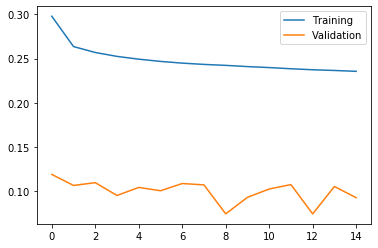

Normalized confusion matrix
[[0.88 0.12]
 [0.   1.  ]]
total accuracy = 0.9956


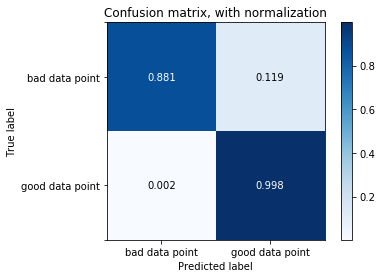

In [24]:
epochCount = 15
batchCount = 64
classThreshold = .5
numFeatures = 5
modelOutBalanced = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, 
               epochCount, batchCount, classThreshold, numFeatures)

Try running a new model with 7 features, adding in the neighbor residual and boolean variables

In [7]:
cmTrainRandResample=shuffle(cmTrainResample)

featureTrain=cmTrainRandResample.loc[:,['primary','sigma','backup','prediction','residual','neighborResidual','neighborTrue']]
featureTest=cmTestRand.loc[:,['primary','sigma','backup','prediction','residual','neighborResidual','neighborTrue']]

targetTrain=cmTrainRandResample.loc[:,['goodPts']]
targetTest=cmTestRand.loc[:,['goodPts']]

predictFeatures = cmTestScaled.loc[:,['primary','sigma','backup','prediction','residual','neighborResidual','neighborTrue']]

Train on 98764 samples, validate on 223835 samples
Epoch 1/25
98764/98764 [==============================] - 11s 108us/step - loss: 0.2942 - accuracy: 0.8970 - val_loss: 0.1445 - val_accuracy: 0.9862
Epoch 2/25
98764/98764 [==============================] - 10s 104us/step - loss: 0.2562 - accuracy: 0.9121 - val_loss: 0.1086 - val_accuracy: 0.9883
Epoch 3/25
98764/98764 [==============================] - 10s 103us/step - loss: 0.2491 - accuracy: 0.9141 - val_loss: 0.1119 - val_accuracy: 0.9875
Epoch 4/25
98764/98764 [==============================] - 10s 103us/step - loss: 0.2440 - accuracy: 0.9147 - val_loss: 0.1343 - val_accuracy: 0.9852
Epoch 5/25
98764/98764 [==============================] - 10s 98us/step - loss: 0.2395 - accuracy: 0.9152 - val_loss: 0.1124 - val_accuracy: 0.9887
Epoch 6/25
98764/98764 [==============================] - 10s 96us/step - loss: 0.2360 - accuracy: 0.9154 - val_loss: 0.1076 - val_accuracy: 0.9893
Epoch 7/25
98764/98764 [==============================] -

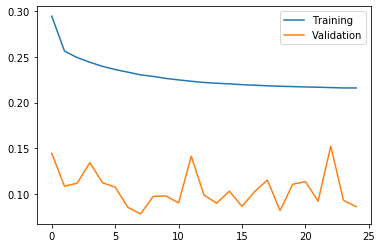

Normalized confusion matrix
[[0.85 0.15]
 [0.01 0.99]]
total accuracy = 0.9885


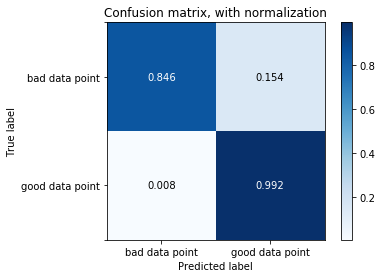

In [16]:
epochCount = 25
batchCount = 64
classThreshold = .5
numFeatures = 7
modelOutWithNeighbor = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, 
               epochCount, batchCount, classThreshold, numFeatures)

In [19]:
#import dill
#dill.load_session('notebook_env.db')
#dill.dump_session('notebook_env.db')

Normalized confusion matrix
[[0.84 0.16]
 [0.   1.  ]]
total accuracy = 0.9921


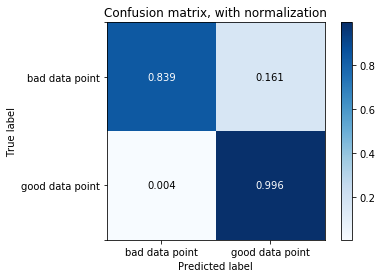

In [18]:
#This is for testing different thresholds with the results of the model

classThreshold =.4
modelPredThresh=1*(modelOutWithNeighbor['modelPrediction'] >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(modelOutWithNeighbor['goodPts'] , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()

Now lets try using some simpler models from scikit learn, will try logistic regression and random forrest

In [ ]:
#This is to prep targets for fitting in scikit-learn
targetTrainIn=np.ravel(targetTrain)
targetTestIn=np.ravel(targetTest)

In [ ]:
%%time
# Fitting a Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(featureTrain, targetTrainIn)

In [ ]:
# prediction on the training dataset
trainAccuracy = 1 - np.sum(np.abs(clf.predict(featureTrain) - targetTrainIn))/len(targetTrainIn)
print('Accuracy on the train dataset is '+ str(trainAccuracy))

In [ ]:
# prediction on the testing dataset
testAccuracy = 1 - np.sum(np.abs(clf.predict(featureTest) - targetTestIn))/len(targetTestIn)
print('Accuracy on the test dataset is '+ str(testAccuracy))

In [ ]:
#Generate predictions for the test period
modelPrediction = model.predict(predictFe, batch_size=32)

In [ ]:
predictFeatures.head()

In [ ]:
modelOut=predictFeatures
modelOut['modelPrediction']=modelPrediction
modelOut['InvModelPrediction']=1-modelPrediction
modelOut['goodPts'] = cmTest.loc[:,['goodPts']]

In [ ]:
modelOut.head()

In [ ]:
forPlot=modelOut.loc['2015-01-01 00:00:00':'2015-04-01 00:00:00',:]
forPlot.head()

In [ ]:
plotExample = forPlot.hvplot.scatter( 'time','primary',c='InvModelPrediction',cmap = 'viridis', colorbar = True, size = 10)
